<a href="https://colab.research.google.com/github/Fatma-Chaouech/PyTorch-Learning-Journey/blob/main/Intermediate_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

%matplotlib inline

# Tensors

In PyTorch, if a torch method ends with an underscore, it means that it directly affects the value of the passed variable, like inplace=True.

We could also specify a variable that will contain the resulting value using the argument "out". The variable specified in "out" will be the exact same object as the variable that we affected the result to. Let's see a quick example :

In [ ]:
a = torch.rand(2, 2)
b = torch.rand(2, 2)
c = torch.zeros(2, 2)
old_id = id(c)

print(c)
d = torch.matmul(a, b, out=c)
print(c)                # contents of c have changed

assert c is d           # test c & d are same object, not just containing equal values
assert id(c), old_id    # make sure that our new c is the same object as the old one

tensor([[0., 0.],
        [0., 0.]])
tensor([[0.2058, 0.1343],
        [1.1684, 1.1062]])


Variable assigning in PyTorch doesn't generate a copy. If you want a separate copy of the data to work on, you should use the clone() method. 

In [ ]:
# simple assigning
v = torch.ones(2, 2)
u = v

v[0][1] = 561  # we change a...
print(v)       # ...and b is also altered


# using clone()
a = torch.ones(2, 2)
b = a.clone()

assert b is not a      # different objects in memory...
print(torch.eq(a, b))  # ...but still with the same contents!

a[0][1] = 561          # a changes...
print(b)               # ...but b is still all ones

tensor([[  1., 561.],
        [  1.,   1.]])
tensor([[True, True],
        [True, True]])
tensor([[1., 1.],
        [1., 1.]])


**It's important to note that if your source tensor has autograd, enabled then so will the clone.** If you want to turn off the autograd, use the detach() method before cloning.

# GPU Computing

We first need to check if we have a GPU available with .is_available() method.

In [ ]:
if torch.cuda.is_available():
    print('We have a GPU!')
else:
    print('Sorry, CPU only.')

We have a GPU!


The CPU does computation on data in the computer's RAM. However, **the GPU has dedicated memory attached to it.** Thus, we should move all the data needed for that computation to memory accessible by the GPU. We often say that we "move the data to the GPU".

There are many ways to make your data accessible by the device. 
* At creation time : specify to the argument device='cuda' with the creation of the tensor object.
* Create a torch.device object and pass it as argument to your tensor objects.
* If you already have created your tensor object, you can use `.to()` method to move it to the gpu.

**Note : In order to do computation involving two or more tensors, all of the tensors must be on the same device.**

In [ ]:
if torch.cuda.is_available():
  # at creation
  gpu_rand = torch.rand(2, 2, device='cuda')

  # create device object
  my_device = torch.device('cuda')
  gpu_rand = torch.rand(2, 2, device=my_device)

  # move an existing object
  gpu_rand = gpu_rand.to(my_device)

# Manipulating Tensor Shapes



In [ ]:
a = torch.rand(3, 226, 226)
c = torch.rand(1, 20)

# add a dimension of extent 1 as a zeroth dimension
b = a.unsqueeze(0)

# squeeze the zeroth dimension
d = c.squeeze(0)

Note : 
* if you try to squeeze a torch with no dimension of extent 1, nothing will happen.
* if you want the squeeze (respectively unsqueeze) method to act directy on the torch (inplace=True), use `squeeze_()` (respectively `unsqueeze_()`)

# NumPy Bridge

It's easy to switch between a numpy array and a tensor.

In [ ]:
# from numpy to torch
a = np.ones((2, 4))
b = torch.from_numpy(a)

# from torch to numpy
c = torch.ones((2, 4))
d = np.array(c)

**It is important to know that these converted objects are using the same underlying memory as their source objects. If you want to create another object, use the `clone()` method.**

# Autograd

Autograd tracks the history of every computation. Every computed tensor in your PyTorch model carries a history of its input tensors and the function used to create it. Combined with the fact that PyTorch functions meant to act on tensors each have a built-in implementation for computing their own derivatives, this greatly speeds the computation of the local derivatives needed for learning. 

Here's how autograd is used.

In [ ]:
a = torch.linspace(0, 10, steps=25, requires_grad=True) # autograd will be accumulating the history of the computation in the output tensors of that computation
print(a)

tensor([ 0.0000,  0.4167,  0.8333,  1.2500,  1.6667,  2.0833,  2.5000,  2.9167,
         3.3333,  3.7500,  4.1667,  4.5833,  5.0000,  5.4167,  5.8333,  6.2500,
         6.6667,  7.0833,  7.5000,  7.9167,  8.3333,  8.7500,  9.1667,  9.5833,
        10.0000], requires_grad=True)


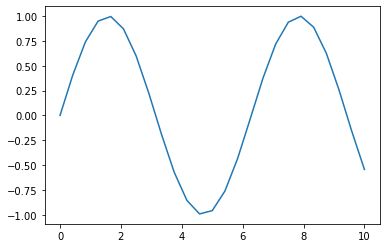

In [ ]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())  # plotting requires the detach

Now, if we print b, we're going to see that the sin function is registered.

In [ ]:
print(b)

tensor([ 0.0000,  0.4047,  0.7402,  0.9490,  0.9954,  0.8715,  0.5985,  0.2230,
        -0.1906, -0.5716, -0.8548, -0.9917, -0.9589, -0.7621, -0.4348, -0.0332,
         0.3742,  0.7175,  0.9380,  0.9980,  0.8873,  0.6247,  0.2553, -0.1579,
        -0.5440], grad_fn=<SinBackward0>)


Let's do some more computation.

In [ ]:
b = b * 2 + 1
print(b)

tensor([ 1.0000,  1.8094,  2.4804,  2.8980,  2.9908,  2.7430,  2.1969,  1.4461,
         0.6189, -0.1431, -0.7095, -0.9834, -0.9178, -0.5242,  0.1303,  0.9336,
         1.7483,  2.4349,  2.8760,  2.9961,  2.7746,  2.2494,  1.5105,  0.6842,
        -0.0880], grad_fn=<AddBackward0>)


Finally, let's call the `backward()` method on a tensor. But first, we should compute a single-element output, since the `backward()` methods expects the calling tensor to only contain a single element.

In [ ]:
out = b.sum()
print(out)

# Visualize the history of b
functions = b.grad_fn.next_functions
print(functions)
print(b.grad_fn.next_functions[0][0].next_functions)
print(b.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(b.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\n')
print(a.grad)
print('\n')

out.backward()
# the derivative of a
print(a.grad)

tensor(33.1554, grad_fn=<SumBackward0>)
((<MulBackward0 object at 0x7fac398064c0>, 0), (None, 0))
((<SinBackward0 object at 0x7fac397df370>, 0), (None, 0))
((<AccumulateGrad object at 0x7fac39806ee0>, 0),)
()


None


tensor([ 2.0000,  1.8289,  1.3448,  0.6306, -0.1914, -0.9808, -1.6023, -1.9496,
        -1.9633, -1.6411, -1.0381, -0.2574,  0.5673,  1.2950,  1.8010,  1.9989,
         1.8547,  1.3932,  0.6933, -0.1253, -0.9224, -1.5617, -1.9337, -1.9749,
        -1.6781])


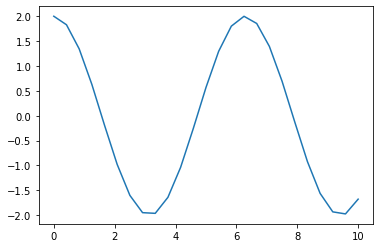

In [ ]:
# display the gradient of a
plt.plot(a.detach(), a.grad.detach())

**Note that only leaf nodes of the computation have their gradients computed.**